In [3]:
from percolation import TemporalPercolation
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import itertools

In [4]:
def preprocess(dataset_name: str):
    """
    read the original data file and return the DataFrame that has columns ['u', 'i', 'ts', 'label', 'idx']
    :param dataset_name: str, dataset name
    :return:
    """
    u_list, i_list, ts_list, label_list = [], [], [], []
    idx_list = []

    with open(dataset_name) as f:
        # skip the first line
        s = next(f)
        for idx, line in enumerate(f):
            e = line.strip().split(' ')
            # user_id
            u = int(e[0])
            # item_id
            i = int(e[1])

            # timestamp
            ts = float(e[2])
            
            u_list.append(u)
            i_list.append(i)
            ts_list.append(ts)
            
            # edge index
            idx_list.append(idx)

            
    return pd.DataFrame({'u': u_list,
                         'i': i_list,
                         'ts': ts_list,
                         'idx': idx_list})

In [5]:
file_path = "CollegeMsg.txt"
bipartite = True

df  = preprocess(file_path)
print(df.head()) 

df['normalized_ts'] = (df['ts'] - df['ts'].min()) / 3600  

print("Normalized Timestamp Range:", df['normalized_ts'].min(), "-", df['normalized_ts'].max())

tedges = list(df[['u', 'i', 'normalized_ts']].itertuples(index=False, name=None))

temporal_graph = pp.TemporalGraph.from_edge_list(tedges)
total_events = len(tedges)

bipartite_percolation = TemporalPercolation(temporal_graph, total_events)

print("Min Timestamp:", df['normalized_ts'].min())
print("Max Timestamp:", df['normalized_ts'].max())

delta_t_values = np.linspace(df['normalized_ts'].min(), df['normalized_ts'].max(), 50)

# Based on my observation, I refined the delta_t_values
refined_delta_t_values = np.linspace(0.0, 134585.44939271256/ 3600 , num=20) # 37.3848471 hours
refined_delta_t_values2 = np.linspace(154585.449392712560/ 3600 , 1332000.0/ 3600 , num=20) # 37.3848471 hours

#combined_delta_t_values = np.unique(np.concatenate((delta_t_values, refined_delta_t_values, refined_delta_t_values2)))

# analysis_results, percolation_metrics = bipartite_percolation.percolation_analysis(combined_delta_t_values)

# with open("UCIcollegeMsg_results/analysis_results_hours.json", "w") as file:
#     json.dump(analysis_results, file, indent=4)

with open("UCIcollegeMsg_results/analysis_results_hours.json", "r") as file:
    analysis_results = json.load(file)


   u   i            ts  idx
0  3   4  1.082156e+09    0
1  5   2  1.082414e+09    1
2  6   7  1.082440e+09    2
3  8   7  1.082440e+09    3
4  9  10  1.082440e+09    4
Normalized Timestamp Range: 0.0 - 4617.028611111111
Min Timestamp: 0.0
Max Timestamp: 4617.028611111111


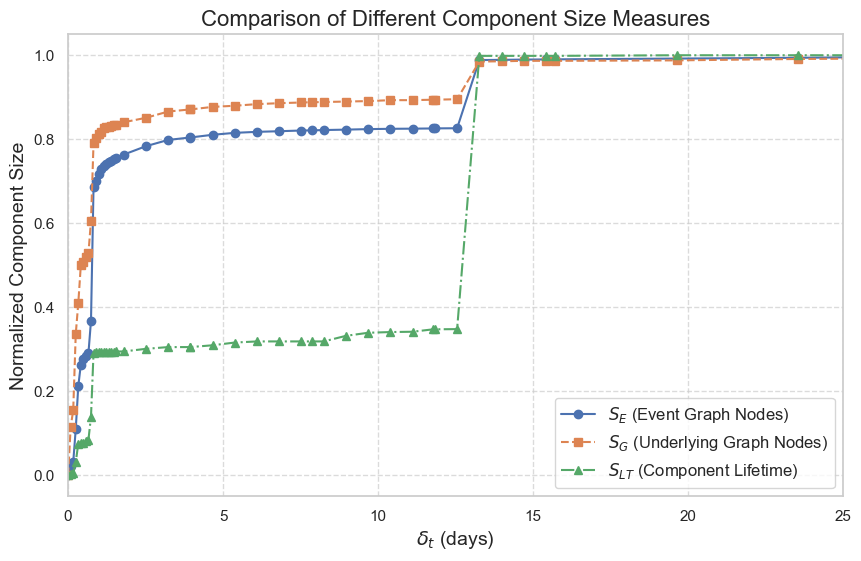


Correlation between measures:
           S_E       S_G      S_LT
S_E   1.000000  0.983535  0.835873
S_G   0.983535  1.000000  0.772231
S_LT  0.835873  0.772231  1.000000


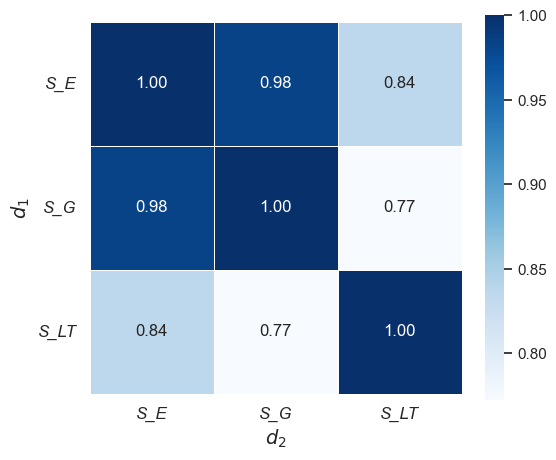

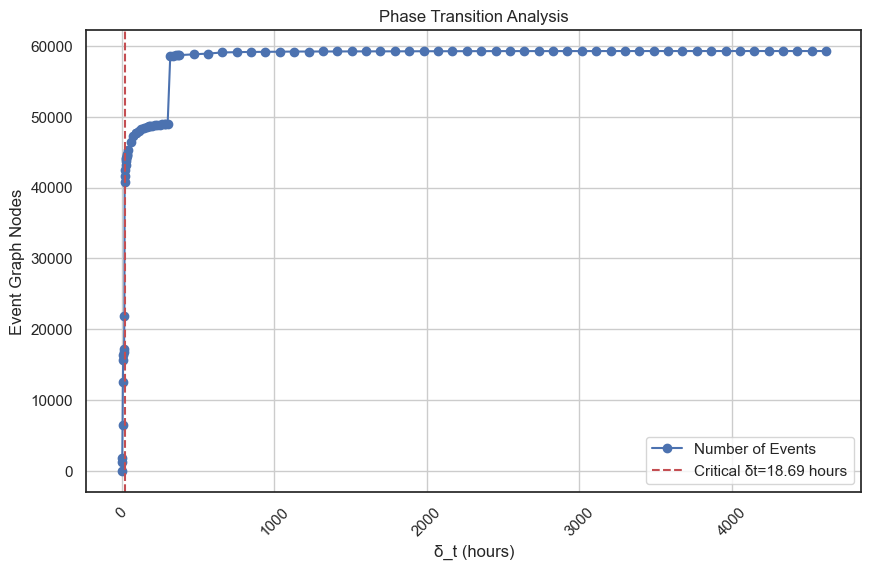

In [6]:
delta_t_values = np.array([float(k) for k in analysis_results.keys()])

bipartite_percolation.compare_component_measures(analysis_results)
bipartite_percolation.plot_largest_component(analysis_results, delta_t_values)

Total Values:
NE: 59834, NG: 1899, NLT: 4617.02880859375


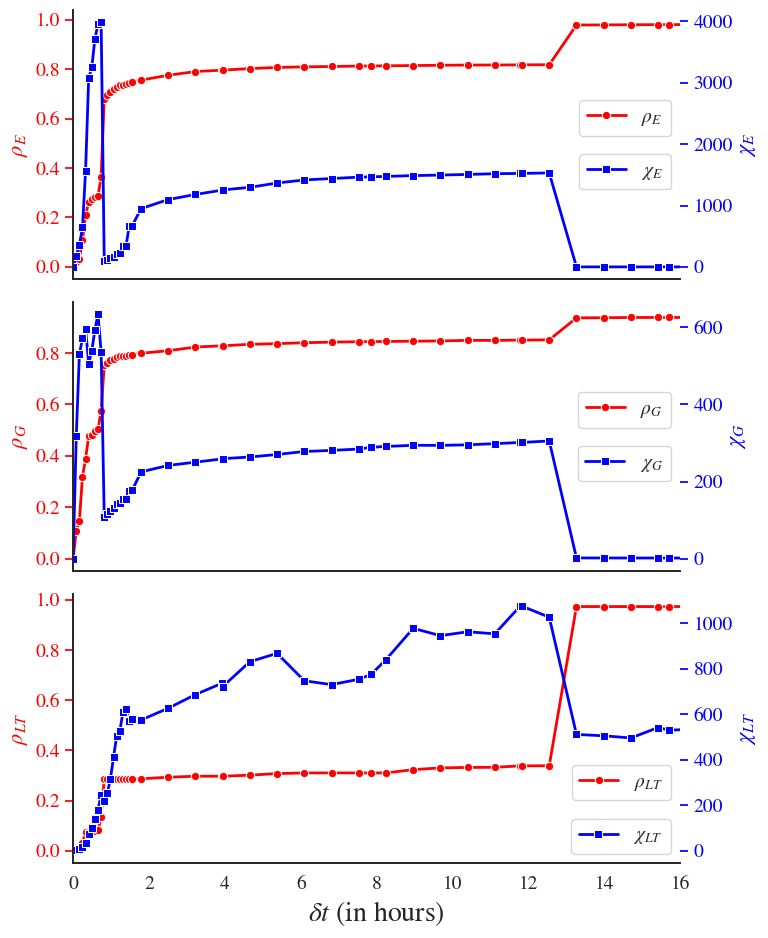

In [7]:
delta_t_values, rho_E, rho_G, rho_LT, chi_E, chi_G, chi_LT, P_S_E_distributions, P_S_LT_distributions, P_S_G_distributions = bipartite_percolation.compute_order_parameters(analysis_results, temporal_graph)


rho_metrics = [rho_E, rho_G, rho_LT]
chi_metrics = [chi_E, chi_G, chi_LT]
labels = [(r'$\rho_E$', r'$\chi_E$'), (r'$\rho_G$', r'$\chi_G$'), (r'$\rho_{LT}$', r'$\chi_{LT}$')]

colors = ('red', 'blue')

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "axes.titlesize": 20,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral"
})

bipartite_percolation.plot_percolation_metrics(delta_t_values/24, rho_metrics, chi_metrics, labels, colors, time_range=16)


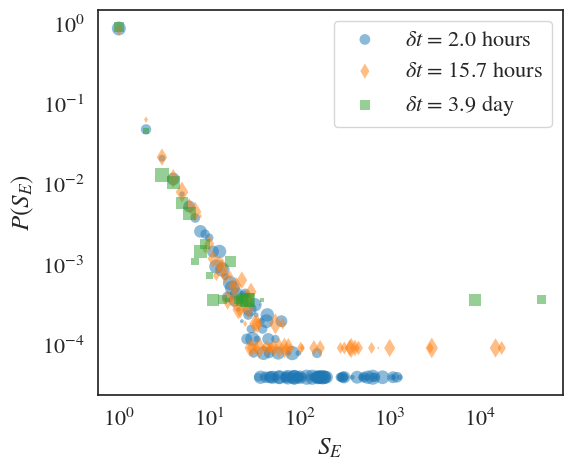

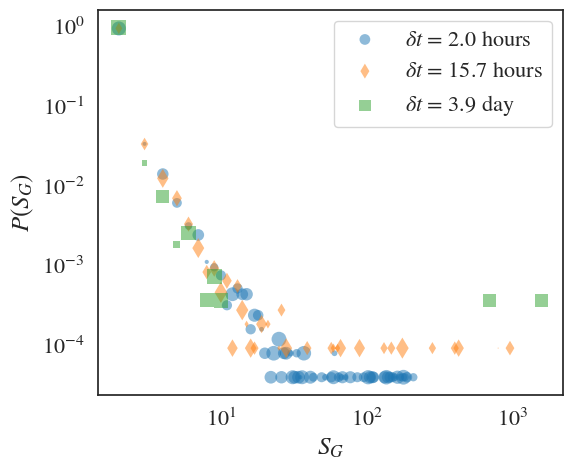

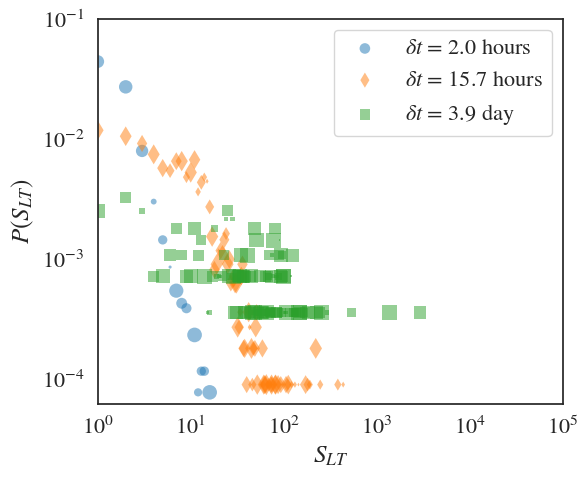

In [8]:
selected_delta_t_values = [1.9676235291332247, 15.740988233065798,94.58139167080995]

color_cycle = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green'])
marker_cycle = itertools.cycle(['o', 'd', 's'])

colors = {dt: next(color_cycle) for dt in selected_delta_t_values}
markers = {dt: next(marker_cycle) for dt in selected_delta_t_values}

# P(S_E)
fig, ax = plt.subplots(figsize=(6, 5))
for dt in selected_delta_t_values:
    if dt in P_S_E_distributions:
        sizes = np.array(list(P_S_E_distributions[dt].keys()))
        probabilities = np.array(list(P_S_E_distributions[dt].values()))
        scale = 120.0 * np.random.rand(len(sizes)) 

        if dt > 24:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt/24:.1f} day",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')
        else:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt:.1f} hours",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$S_E$")
ax.set_ylabel("$P(S_E)$")
ax.legend()
plt.show()

# P(S_G)
fig, ax = plt.subplots(figsize=(6, 5))
for dt in selected_delta_t_values:
    if dt in P_S_G_distributions:
        sizes = np.array(list(P_S_G_distributions[dt].keys()))
        probabilities = np.array(list(P_S_G_distributions[dt].values()))
        scale = 120.0 * np.random.rand(len(sizes))

        if dt > 24:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt/24:.1f} day",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')
        else:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt:.1f} hours",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$S_{G}$")
ax.set_ylabel("$P(S_{G})$")
ax.legend(loc="upper right")
plt.show()

# P(S_LT)
fig, ax = plt.subplots(figsize=(6, 5))
for dt in selected_delta_t_values:
    if dt in P_S_LT_distributions:
        sizes = np.array(list(P_S_LT_distributions[dt].keys()))
        probabilities = np.array(list(P_S_LT_distributions[dt].values()))
        scale = 120.0 * np.random.rand(len(sizes))

        if dt > 24:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt/24:.1f} day",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')
        else:
            ax.scatter(sizes, probabilities,
                    label=rf"$\delta t$ = {dt:.1f} hours",
                    marker=markers[dt], c=colors[dt],
                    s=scale, alpha=0.5, edgecolors='none')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**0, 10**5)  

ax.set_ylim(10**-4.2, 10**-1)  
ax.set_xlabel("$S_{LT}$")
ax.set_ylabel("$P(S_{LT})$")
ax.legend(loc="upper right")
plt.show()